In [1]:
%load_ext autoreload
%autoreload 2
# Reload modules if they've changed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline
import flowField   
import impulseResponse as impres
import ops  # Linear dynamical system
import pseudo   # Wall-normal differentiation
import os


# Wall-normal differentiation

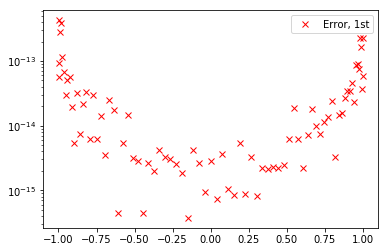

In [257]:
N = 81; nDiff = 2
y,DM = pseudo.chebdif(N,nDiff)
# y has shape (N,), and DM has shape (N,N,nDiff), nDiff is the number of derivatives needed
D1 = DM[:,:,0]
D2 = DM[:,:,1]

# We'll check results against test functions that are 0 at y= +/- 1 
a1 = 11.; i1=6; a2=-4.; i2=13
testFunction = (1-y**2) * ( a1*(y**i1) + a2*(y**i2)  )
firstDerivative = -2.*y*(a1*y**i1 + a2*y**i2) + (1.-y**2)*(
    a1*i1*y**(i1-1) + a2*i2*y**(i2-1))

plt.semilogy(y, np.abs(firstDerivative-D1@testFunction), 'rx', label='Error, 1st')

if False:
    #secondDerivative = 
    #plt.loglog(y, secondDerivative-D2@testFunction, 'b--', label='Error, 2nd')
    pass
plt.legend()
plt.show()



# Impulse response for channel flow

## $Re_\tau = 500$, turbulent, with eddy viscosity
## At $y^+=50$, and forced along each coordinate axis

# For a single Fourier mode, $(\alpha,\beta)=(2., 7.)$
At times, $t=\lbrack t_0:t_0:20t_0\rbrack$, $t_0 = 0.05$, non-dimensionalized by friction velocity and channel half-height.

/home/svadarevu/gitwork/linear/library/ops.py:243: UserWarning: Base velocity is being reset using ops.turbMeanChannel...
  warn('Base velocity is being reset using ops.turbMeanChannel...')


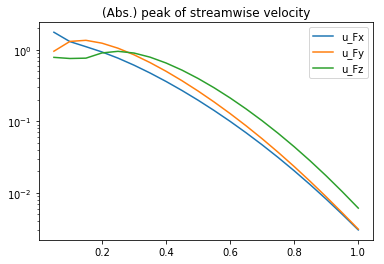

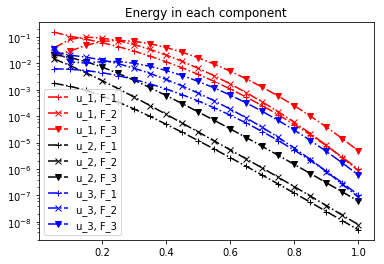

In [75]:
Re = 500.
N = 151 
# N must increase with increasing Re
turb = True

# Define 'linearize' class instance
linInst = ops.linearize(
            N=N, flowClass='channel', Re=Re, turb=turb)
# U, dU, and d2U (mean velocity and its derivatives) are defined by the class if 
#  not supplied, depending on the keyword 'turb'. 
# If False, U=1-y^2. 
# If True, they're obtained from ops.turbMeanChannel()


# System matrices can be obtained as
a = 2.; b = 7.
eddy = True
if False:
    systemDict = linInst.makeSystem(
        a=a, b=b, eddy=eddy, adjoint=True)
    A = systemDict['A']; B = systemDict['B']; C = systemDict['C']
    Aadj = systemDict['Aadj']; Badj = systemDict['Badj']; Cadj = systemDict['Cadj']

    
# Define impulse parameters
tArr = 0.05 * np.arange(1, 21)
fsAmp = np.identity(3)
# fsAmp defines forcing direction. It has to be shape (nForce, 3)
# Each of fsAmp[i,:] defines one case of impulse
# fsAmp[i,:] = (0.5, 0.5, 0) refers to a forcing that is zero along 'z' (spanwise)
#    and equal along 'x' (streamwise) and 'y' (wall-normal)
# The magnitudes 0.5 and 0.5 in the above case are not important, and they will be normalized

y0plus = 50. 
y0 = -1. + y0plus/Re    # This is the variable that has to be passed to code, not y0plus
eps = y0plus/4.    
# y0, eps, N, Re have to be supplied in a dict 'impulseArgs'
# y0 is the center of the approximate impulse, and eps specifies its width
#   Smaller 'eps' produces a sharper impulse, a larger one produces a smoother one. 
# For turbulent cases use eps ~ y0plus, while for laminar, use eps ~ (1/1000)
impulseArgs = {'y0':y0, 'eps':eps}
# See impulseResponse._fs0() for details
coeffs = True       # Flag to say we want Fourier coefficients as well as energy

# Compute impulse response 
impresDict = impres.timeMap(a,b,tArr,
         fsAmp=fsAmp, linInst=linInst, impulseArgs=impulseArgs,
         coeffs=coeffs, eddy=eddy )


# Unpack dictionary
coeffArr = impresDict['coeffArr'] # This has shape (tArr.size, 3N, nForce)
uPeaks = np.amax( np.abs(coeffArr[:,:N]) , axis=1) # Peak uu at each time 

energyArr = impresDict['energyArr'] # Has shape (tArr.size, 3, nForce)




plt.figure()
plt.title("(Abs.) peak of streamwise velocity")
plt.semilogy(tArr, uPeaks[:,0], label='u_Fx')
plt.semilogy(tArr, uPeaks[:,1], label='u_Fy')
plt.semilogy(tArr, uPeaks[:,2], label='u_Fz')
plt.legend()
plt.show()

plt.figure()
plt.title("Energy in each component")
clrArr = ['r','k','b']
symArr = ['+', 'x', 'v']
for i0 in range(3):
    for i1 in range(3):
        plt.semilogy(tArr, energyArr[:,i0,i1], 
                     '%s-.%s'%(clrArr[i0], symArr[i1]),
                     label='u_%d, F_%d'%(i0+1,i1+1))
plt.legend()
plt.show()




# Impulse response for a set of $(\alpha, \beta)$
## Turbulent, with eddy viscosity, $Re_\tau = 500$, forcing at $y^+ = 25$ along coordinate axes

In [76]:
Re = 500.; N = 151
turb = True; eddy = True
y0plus = 25.
fsAmp = np.identity(3)

Lx = 2.*np.pi; Lz = np.pi   # Domain size
L = 32; M = 32  # Number of positive Fourier wavenumbers 
t0 = 0.05; tArr = t0*np.arange(1., 11.)   # Time

#================================
a0 = 2.*np.pi/Lx; b0 = 2.*np.pi/Lz
eps = y0plus/4.; y0 = -1. + y0plus/Re
aArr = a0*np.arange(-L,L); bArr = b0*np.arange(0,M+1)
# bArr doesn't need negative wavenumbers, we can use real-valuedness to complete those coefficients


#Impulse response can be computed in two ways. 






## 1. Call impres.timeMap() explicitly and populate flowField instance for each time


In [82]:
#flowField(aArr, bArr, N, flowDict=flowDict); flowDict has keys 
flowState = 'turb'
if not turb: flowState = 'lam'
ffList =[]

#=== Need these two to call impres.timeMap()
linInst = ops.linearize(N=N,flowClass='channel',Re=Re,turb=turb)
impulseArgs = {'y0':y0, 'eps':eps}

for i0 in range(tArr.size):
    t = tArr[i0]
    print("t:",t)
    for i3 in range(fsAmp.shape[0]):
        fsAmpVec = fsAmp[i3:i3+1]
        flowDict={'Re':Re, 'N':N, \
         'flowState':flowState, 'flowClass':'channel', 'eddy':eddy, 't':t}
        # Need a new instance of flowField.flowField for each time and forcing
        ff = flowField.flowField(aArr, bArr, N, flowDict=flowDict)
        # ff has shape (aArr.size, bArr.size, 3, N)
        for i1 in range(aArr.size):
            a = aArr[i1]
            for i2 in range(bArr.size):
                b = bArr[i2]
                impresDict = impres.timeMap(a,b,tArr[i0:i0+1], fsAmp=fsAmpVec,
                            coeffs=True,linInst=linInst, eddy=eddy, impulseArgs=impulseArgs)
                ff[i1,i2] = impresDict['coeffArr'].reshape((3,N))
        ffList.append(ff)
                


t: 0.05


/home/svadarevu/gitwork/linear/library/flowField.py:543: UserWarning: Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.
  warn("Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.")
/home/svadarevu/gitwork/linear/library/ops.py:243: UserWarning: Base velocity is being reset using ops.turbMeanChannel...
  warn('Base velocity is being reset using ops.turbMeanChannel...')
/home/svadarevu/gitwork/linear/library/ops.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  C = (1./k2) * np.vstack((
/home/svadarevu/gitwork/linear/library/ops.py:301: RuntimeWarning: invalid value encountered in multiply
  np.hstack((1.j*b*D1,  1.j*a*I1)) ))


KeyboardInterrupt: 

The above way of computing impulse response is very inefficient. Instead,
## 2. Call flowField.impulseResponse() or flowField.impulseResponse_split()


In [86]:
#=============================================
# Since a lot of flowFields are involved, it's better to save them to disk
#   instead of keeping them on RAM for post-processing
fPrefix = 'testFields/testImpres_ffEddyRe%dy0p%d'%(Re,round(-1000*y0))
import os
if not os.path.isdir('testFields'): os.mkdir("testFields")
#==========================

flowState = 'turb'
if not turb: flowState = 'lam'
flowDict = {'Re':Re, 'N':N, 'flowState':flowState,'flowClass':'channel','eddy':eddy}

splitRuns = False
if not splitRuns:
    impresOut = flowField.impulseResponse(aArr, bArr, N, tArr, fsAmp=fsAmp, 
                    flowDict=flowDict, impulseArgs={'y0':y0,'eps':eps},
                    fPrefix = fPrefix)
    # impresOut is a np.ndarray of size (tArr.size,fsAmp.shape[0],aArr.size,bArr.size,3,N)
    # Because fPrefix was supplied, files are also stored to disk. 
    # Their names are
    #  fPrefix+'_Fs_1_0_0_t00005.mat' for forcing direction [1,0,0] and time (00005/100)

#==================================================
# Alternatively, split the above run into parts as follows
if splitRuns:
    # The function flowField.impulseResponse_split() takes two 
    #   additional positional arguments, na and nb, which specify the number of
    #   chunks to split the run into along aArr and bArr
    na = 4; nb = 1
    # impulseResponse_split() has null output
    flowField.impulseResponse_split(aArr, bArr, N, tArr, na, nb,
                    fsAmp=fsAmp, flowDict=flowDict, impulseArgs={'y0':y0,'eps':eps},
                    fPrefix = fPrefix)
    
    # These files are saved to disk as
    # fPrefix+'_aPart2_4_Fs_1_0_0_t00005.mat' for the 2nd chunk of wavenumbers 
    #    for forcing direction [1,0,0] and time (00005/100)
    
if False:
    impresOut = None  # Clear this large array from RAM
    
    

Flow parameters are (Re,N,eddy,turb): (500.0, 151, True, True)
Running impres with y0p, eps : 25, 6.25
And fsAmp: [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
For N and Re: 151 500.0
a: -32.0


/home/svadarevu/gitwork/linear/library/ops.py:243: UserWarning: Base velocity is being reset using ops.turbMeanChannel...
  warn('Base velocity is being reset using ops.turbMeanChannel...')


a: -31.0
a: -30.0
a: -29.0
a: -28.0
a: -27.0
a: -26.0
a: -25.0
a: -24.0
a: -23.0
a: -22.0
a: -21.0
a: -20.0
a: -19.0
a: -18.0
a: -17.0
a: -16.0
a: -15.0
a: -14.0
a: -13.0
a: -12.0
a: -11.0
a: -10.0
a: -9.0
a: -8.0
a: -7.0
a: -6.0
a: -5.0
a: -4.0
a: -3.0
a: -2.0
a: -1.0
a: 0.0
a: 1.0
a: 2.0
a: 3.0
a: 4.0
a: 5.0
a: 6.0
a: 7.0
a: 8.0
a: 9.0
a: 10.0
a: 11.0
a: 12.0
a: 13.0
a: 14.0
a: 15.0
a: 16.0
a: 17.0
a: 18.0
a: 19.0
a: 20.0
a: 21.0
a: 22.0
a: 23.0
a: 24.0
a: 25.0
a: 26.0
a: 27.0
a: 28.0
a: 29.0
a: 30.0
a: 31.0


/home/svadarevu/gitwork/linear/library/flowField.py:545: UserWarning: Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.
  D1 = np.ascontiguousarray(DM[:,:,0])


Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_1_0_0_t00005.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_1_0_t00005.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_0_1_t00005.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_1_0_0_t00010.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_1_0_t00010.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_0_1_t00010.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_1_0_0_t00015.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_1_0_t00015.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_0_1_t00015.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_1_0_0_t00020.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_1_0_t00020.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_

# Loading saved flowfields

In [103]:
fPrefix = 'testFields/testImpres_ffEddyRe%dy0p%d'%(Re,int(round(-1000*y0)))

_suffix = lambda fsVec,t: '_Fs_%d_%d_%d_t%05d.mat'%(fsVec[0],fsVec[1],fsVec[2],int(round(100*t)))

fsVec = np.array([1., 0., 0.])
t = 0.5

if not splitRuns:
    ff = flowField.loadff(fPrefix + _suffix(fsVec,t))
else :
    ff = flowField.loadff_split(fPrefix, t, fsAmp=fsVec, na=na,nb=nb)

Loaded flowField from  testFields/testImpres_ffEddyRe500y0p950_Fs_1_0_0_t00050.mat


/home/svadarevu/gitwork/linear/library/flowField.py:545: UserWarning: Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.
  warn("Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.")


# Produce physical field from spectral fields

In [107]:
# Streamwise velocity in physical space:
#uPhysDict = ff.toPhysical(arr=ff[:,:,0], x0=12*ff.flowDict['t'], lx=15.*ff.flowDict['t'], 
#              z0=5.*ff.flowDict['t'], ySpace='cheb', doSort=True, L=L, M=M)
# 'arr' field that is being transformed to physical space
# x0, lx, and z0 specify the physical domain. If set to None, 
#    0., Lx, and -Lz/2. are used. 
# ySpace can be 'cheb' or 'linear'. 
# doSort refers to having to sort aArr and bArr into fft-order. Set to True if unsure. 
# L and M are the number of positive streamwise and spanwise wavenumbers 
#   if they're greater/lesser than the ones used in creating ff, then 
#   the flowfield are padded/truncated. 
# vPhysDict is a dict with keys 'arrPhys', 'xArr', 'yArr', 'zArr'
uPhysDict = ff.toPhysical(arr=ff[:,:,0],doSort=True)


# Swirling strength
#swirlPhysDict = ff.swirl(x0=12*ff.flowDict['t'], lx=15.*ff.flowDict['t'], 
#              z0=5.*ff.flowDict['t'], ySpace='cheb', doSort=True, L=2*L, M=2*M)
swirlPhysDict = ff.swirl(doSort=True)



/home/svadarevu/gitwork/linear/library/flowField.py:729: UserWarning: Ensure input arr confirms to fft order for wavenumbers
  warn("Ensure input arr confirms to fft order for wavenumbers")
/home/svadarevu/gitwork/linear/library/flowField.py:1220: UserWarning: Assuming that modes go positive and negative in kx
  warn("Assuming that modes go positive and negative in kx")


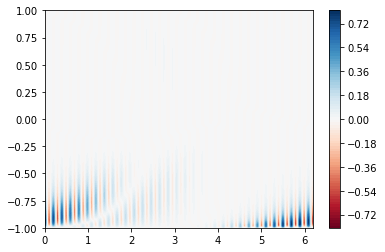

In [115]:
# Contours at z=0 (z is spanwise)
nz = uPhysDict['zArr'].size
xArr = uPhysDict['xArr']; yArr = uPhysDict['yArr']
plt.contourf(xArr, yArr, uPhysDict['arrPhys'][:,nz//2+1,:].T, 100,cmap='RdBu')
plt.colorbar()
plt.show()

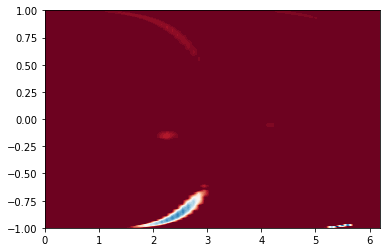

In [109]:
# Contours at z=0 (z is spanwise)
nz = swirlPhysDict['zArr'].size
xArr = swirlPhysDict['xArr']; yArr = swirlPhysDict['yArr']
plt.contourf(xArr, yArr, swirlPhysDict['swirl'][:,nz//2,:].T, 50,cmap='RdBu')
plt.show()

# Save physical fields to .mat file 

In [111]:
fNamePhys = 'testFields/testImpres_physEddyRe%dy0p%d'%(Re,int(round(-1000*y0)))+ \
                _suffix(fsVec, t)

nx = ff.shape[0]; nz = 2*(ff.shape[1]-1)
ff.savePhysical(fieldList=['u','v','w','vorx','swirl','vory','vorz'],
            fName=fNamePhys,
            x0=10.*t, lx=min(25.*t,((nx-2)/nx)*Lx), 
            z0=min(10.*t,((nz-2)/nz)*Lz),
            )

/home/svadarevu/gitwork/linear/library/flowField.py:729: UserWarning: Ensure input arr confirms to fft order for wavenumbers
  warn("Ensure input arr confirms to fft order for wavenumbers")
/home/svadarevu/gitwork/linear/library/flowField.py:1220: UserWarning: Assuming that modes go positive and negative in kx
  warn("Assuming that modes go positive and negative in kx")


Saved fields   ['u', 'v', 'w', 'swirl', 'vorx', 'vory', 'vorz']   to file testFields/testImpres_physEddyRe500y0p950_Fs_1_0_0_t00050.mat


/home/svadarevu/gitwork/linear/library/flowField.py:545: UserWarning: Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.
  warn("Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.")


Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00030.mat


/home/svadarevu/gitwork/linear/library/flowField.py:729: UserWarning: Ensure input arr confirms to fft order for wavenumbers
  warn("Ensure input arr confirms to fft order for wavenumbers")
/home/svadarevu/gitwork/linear/library/flowField.py:1220: UserWarning: Assuming that modes go positive and negative in kx
  warn("Assuming that modes go positive and negative in kx")


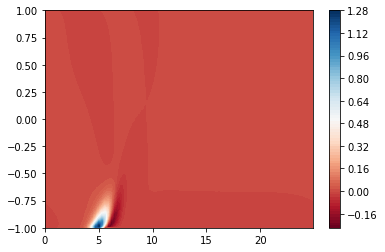

In [117]:
saveFolder = '/kepler/sabarish/impulseResponse/'
specPrefix = saveFolder+'ffEddyRe10000'

fName = specPrefix+'y0p997_Fs_1_0_0_t00030.mat'
ff = flowField.loadff(fName)

# Streamwise velocity in physical space:
#uPhysDict = ff.toPhysical(arr=ff[:,:,0], x0=12*ff.flowDict['t'], lx=15.*ff.flowDict['t'], 
#              z0=5.*ff.flowDict['t'], ySpace='cheb', doSort=True, L=L, M=M)
# 'arr' field that is being transformed to physical space
# x0, lx, and z0 specify the physical domain. If set to None, 
#    0., Lx, and -Lz/2. are used. 
# ySpace can be 'cheb' or 'linear'. 
# doSort refers to having to sort aArr and bArr into fft-order. Set to True if unsure. 
# L and M are the number of positive streamwise and spanwise wavenumbers 
#   if they're greater/lesser than the ones used in creating ff, then 
#   the flowfield are padded/truncated. 
# vPhysDict is a dict with keys 'arrPhys', 'xArr', 'yArr', 'zArr'
uPhysDict = ff.toPhysical(arr=ff[:,:,0],doSort=True)


# Swirling strength
#swirlPhysDict = ff.swirl(x0=12*ff.flowDict['t'], lx=15.*ff.flowDict['t'], 
#              z0=5.*ff.flowDict['t'], ySpace='cheb', doSort=True, L=2*L, M=2*M)
swirlPhysDict = ff.swirl(doSort=True)



# Contours at z=0 (z is spanwise)
nz = uPhysDict['zArr'].size
xArr = uPhysDict['xArr']; yArr = uPhysDict['yArr']
plt.contourf(xArr, yArr, uPhysDict['arrPhys'][:,nz//2+1,:].T, 100,cmap='RdBu')
plt.colorbar()
plt.show()


# Resolvent Analysis

## Singular values for a single Fourier mode and phase speed

Compare with fig.4a of Moarref et. al. (2013), Model-based scaling of streamwise energy density in high-Re turbulent channels

/home/svadarevu/gitwork/linear/library/ops.py:459: UserWarning: getResolventModes(): velocityModes, forcingModes are shape (n_smodes, 3N), so each ROW is a mode, not column
  warn("getResolventModes(): velocityModes, forcingModes are shape (n_smodes, 3N), so each ROW is a mode, not column")


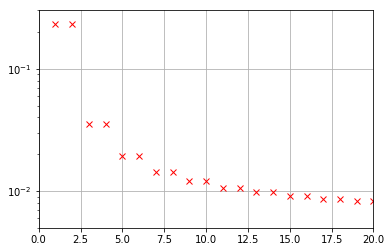

In [19]:
Re = 2003.; N = 251; turb=True; eddy=False
LxPlus = 700.; LzPlus = 100.; c = 10.
a = 2.*np.pi/(LxPlus/Re); b = 2.*np.pi/(LzPlus/Re)
omega = a*c

linInst = ops.linearize(N=N, Re=Re,turb=True)
resDict = linInst.getResolventModes(a,b,a*c, nSvals=20)

sVals = resDict['svals']
plt.semilogy(np.arange(1,sVals.size+1),sVals,'rx')
plt.ylim([0.005,0.3]); plt.xlim([0,20]); plt.grid('on')
plt.show()

## Leading resolvent modes (response) for a single Fourier mode and phase speed

Compare with fig. 3b of Moarref et. al. (2013)

In [200]:
Re = 10000.; N = 401; turb=True; eddy=False
LxPlus = 700.; LzPlus = 100.; c = 10.
a = 2.*np.pi/(LxPlus/Re); b = 2.*np.pi/(LzPlus/Re)
omega = a*c
nSvals=10

print(omega/a)
ff = flowField.resolventMode(a,b,omega, N, Re, 
                turb=turb, eddy=eddy, modeNumber=1,modeSymm=2)
Lext = 25; Mext = 20
physDict = ff.toPhysical(ifft=False, L=Lext, M=Mext)
uPhys = physDict['arrPhys']; 
xArr = physDict['xArr'].flatten()
yArr = physDict['yArr'].flatten()
zArr = physDict['zArr'].flatten()
vPhysDict = ff.toPhysical(arr=ff[:,:,1],ifft=False, L=Lext, M=Mext)
vPhys = vPhysDict['arrPhys']; 
wPhysDict = ff.toPhysical(arr=ff[:,:,2],ifft=False, L=Lext, M=Mext)
wPhys = wPhysDict['arrPhys']; 


xNew = xArr.reshape((xArr.size,1,1))
zNew = zArr.reshape((1,zArr.size,1))
yNew = yArr.reshape((1,1,yArr.size))


/home/svadarevu/gitwork/linear/library/flowField.py:399: UserWarning: Calculating for (a,b,omega) and (-a,b,omega).
  warn("Calculating for (a,b,omega) and (-a,b,omega).")
/home/svadarevu/gitwork/linear/library/flowField.py:400: UserWarning: To set (-a,b,omega) coefficient to zero, set ff[-1] = 0, ff is the returned flowField instance.
  warn("To set (-a,b,omega) coefficient to zero, set ff[-1] = 0, ff is the returned flowField instance.")


10.0
> /home/svadarevu/gitwork/linear/library/flowField.py(407)resolventMode()
-> modeNumber = np.array([modeNumber]).flatten()
(Pdb) c


/home/svadarevu/gitwork/linear/library/flowField.py:407: UserWarning: Same number for resolvent mode used for left and right leaning waves
  modeNumber = np.array([modeNumber]).flatten()
/home/svadarevu/gitwork/linear/library/flowField.py:407: UserWarning: Same wall-normal symmetry is used for left and right leaning waves
  modeNumber = np.array([modeNumber]).flatten()


Relative Frobenius-norm error for SVD is 0.378 for sparse=True with nSvals=2


/home/svadarevu/gitwork/linear/library/ops.py:476: UserWarning: getResolventModes(): velocityModes, forcingModes are shape (n_smodes, 3N), so each ROW is a mode, not column
  warn("getResolventModes(): velocityModes, forcingModes are shape (n_smodes, 3N), so each ROW is a mode, not column")
/home/svadarevu/gitwork/linear/library/flowField.py:407: UserWarning: For mode (-a,b), using reflexive symmetry about z=0 plane:
  modeNumber = np.array([modeNumber]).flatten()
/home/svadarevu/gitwork/linear/library/flowField.py:407: UserWarning: [u,v,w](x,y,-z) = [u,v,-w](x,y,z)
  modeNumber = np.array([modeNumber]).flatten()
/home/svadarevu/gitwork/linear/library/flowField.py:407: UserWarning: Applied as u_{a,b}=u_{a,-b}=conj(u_{-a,b})=conj(u_{-a,-b})
  modeNumber = np.array([modeNumber]).flatten()
/home/svadarevu/gitwork/linear/library/flowField.py:407: UserWarning: This symmetry can be broken (shifted) by setting unequal phases for left and right leaning waves
  modeNumber = np.array([modeNumber

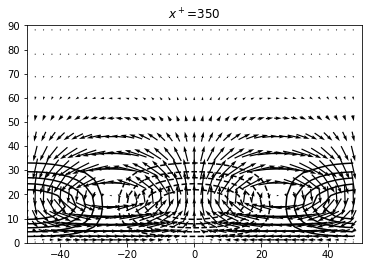

In [217]:
Y = yNew + np.zeros(xNew.shape) + np.zeros(zNew.shape)
Z = zNew + np.zeros(Y.shape)
X = xNew + np.zeros(Y.shape)


arr = uPhys
uMax = np.amax(arr.flatten())
#levels = np.arange(-15,16,3); levels= np.delete(levels,5)
levels = uMax*np.arange(-0.75,0.8,0.15); levels= np.delete(levels,5)
#for ix in [arr.shape[0]//2]:
for ix in [xArr.size//2]:
    plt.contour(zArr*Re, (1.+yArr)*Re, arr[ix].T, 
                colors='k',levels=levels)
    plt.quiver(Re*Z[ix],Re*(1.+Y[ix]), wPhys[ix],vPhys[ix],pivot='middle',units='y',width=0.5,scale=0.75,scale_units='y')
    plt.xlim([-50., 50]); plt.ylim([0., 90.])
    plt.title("$x^+$=%d"%(Re*xArr[ix]))
    plt.show()

if False:
    eddyIntDict = ff.eddyInt()
    yTmp = eddyIntDict['yArr']; uu = eddyIntDict['uu']; uv = eddyIntDict['uv']
    plt.plot(uu, yTmp, 'r-')
    plt.xlim([-1.1*np.amax(uu),1.1*np.amax(uu)])
    plt.show()

    plt.plot(uv, yTmp, 'g:')
    plt.xlim([-1.1,1.1])
    plt.show()
    

### Save the above flowField to .mat file for 3d plotting in Matlab

In [221]:
if not os.path.isdir('testFields'): os.mkdir("testFields")

# savePhysical() can produce physical fields using two routines:
#   ifft (from numpy) or a manual exponentiation routine. 
# ifft matches the number of grid points to the number of Fourier modes, 
#    so it's not advised for resolvent analysis 
ifft = False
doSort = False # This is needed when using ifft; we don't use it here
nx = 50; nz = 50 # Number of grid points to project the flowField on
fieldList = ['u','v','w','vorx','vory','vorz','swirl'] # These fields are supported in savePhysical
fName = "testFields/responseModeTest.mat"
x0=None ; lx = None; z0= None 
#These options are used to truncate the domain when box size is much larger than needed
ySpace = 'cheb' # Retain chebyshev nodes; alternate option is ySpace='linear'

ff.savePhysical(fieldList=fieldList,
                ifft=ifft, doSort=doSort, nx=nx, nz=nz,
                fName=fName, x0=x0,lx=lx, z0=z0, ySpace=ySpace)
    

Saved fields   ['u', 'v', 'w', 'swirl', 'vorx', 'vory', 'vorz']   to file testFields/responseModeTest.mat
